In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats
from astropy.io import fits


from ics.hxutils import hxramp
from h4rg_analysis import ramputils,io, plot

plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 14
bestbaselines = open ('../data/paths/best_ever_baseline_darks_8_21_2022.txt', 'r').read().splitlines()[1:]

In [4]:
gain = 3.2 # e-/ADU, measured by JHU for detector 18660

In [5]:
dtypes_d = ['IRP','data','corr']
colors_d = ['grey','tab:red','b']

In [6]:
ramp_ids =  np.array([ os.path.basename(io.jhu2tiger(bx)).split('.')[0] for bx in bestbaselines ])

In [7]:
idx = np.where(ramp_ids=="PFJB02401923")[0][0]
ramp_path = io.jhu2tiger(bestbaselines[idx])
ramp_id = os.path.basename(ramp_path).split('.')[0] # 'PFJB02401023'
ramp = hxramp.HxRamp ( ramp_path )

In [8]:
cds = ramp.cds ()

In [10]:
r1=50

In [11]:
data = io.dataStack_memmap ( ramp, r1=r1 )

In [12]:
corr = io.corrStack_memmap ( ramp, r1=r1 )

In [ ]:
irp = io.irpStack_memmap ( ramp, r1=r1 )

In [ ]:
tpl = (irp,data,corr)

In [367]:
utrparam_m = np.zeros([3,2,4096,4096])
for ddx in range(3):
    utrparam_m[ddx] = np.load(f'../data/output/{ramp_id}_{dtypes_d[ddx]}_S0-E-1_utrparam.npy')

In [1]:
fig, axarr = plt.subplots ( 2,1, figsize = (12,6))
ypix, xpix = 300,301


indices = np.arange(len(corr))
readtime = ramp.header  ()['W_FRMTIM']
for ddx in range(3):
    utrpred = utrparam_m[ddx, 0,ypix,xpix]*indices + utrparam_m[ddx, 1,ypix,xpix]
    dev_adu = tpl[ddx][:,ypix,xpix] - utrpred
    dev_e = dev_adu * gain
    
    base_color = colors_d[ddx]
    light_color = plot.adjust_value ( base_color )
    axarr[0].plot ( indices*readtime, tpl[ddx][:,ypix,xpix] - utrpred[0], 's-', color=base_color, lw=3)
    axarr[0].plot ( indices*readtime, utrpred - utrpred[0], color=light_color, ls='--', lw=1 )
    axarr[1].plot ( indices*readtime, dev_e, 's-', color=base_color, lw=3 )
axarr[1].axhline ( 0., color='k', ls=':', zorder=0)
for ax in axarr:
    ax.set_xlim(0, indices.max()*readtime )
    ax.set_xlabel ( 'time (s)')
axarr[0].set_ylabel ( r'$Y_i$ (e)')
axarr[1].set_ylabel ( r'$Y_i - R\Delta_t$ (e)')

plt.tight_layout()
plt.savefig(f'../figures/{ramp_id}_UTRzoom_x{xpix}-y{ypix}.png')

NameError: name 'plt' is not defined

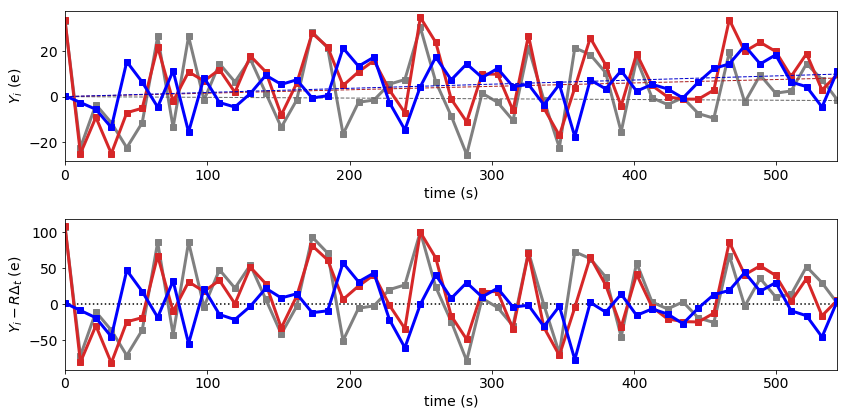

In [428]:
fig, axarr = plt.subplots ( 2,1, figsize = (12,6))
ypix, xpix = 300,300


indices = np.arange(len(corr))
readtime = ramp.header  ()['W_FRMTIM']
for ddx in range(3):
    utrpred = utrparam_m[ddx, 0,ypix,xpix]*indices + utrparam_m[ddx, 1,ypix,xpix]
    dev_adu = tpl[ddx][:,ypix,xpix] - utrpred
    dev_e = dev_adu * gain
    
    base_color = colors_d[ddx]
    light_color = plot.adjust_value ( base_color )
    axarr[0].plot ( indices*readtime, tpl[ddx][:,ypix,xpix] - utrpred[0], 's-', color=base_color, lw=3)
    axarr[0].plot ( indices*readtime, utrpred - utrpred[0], color=light_color, ls='--', lw=1 )
    axarr[1].plot ( indices*readtime, dev_e, 's-', color=base_color, lw=3 )
axarr[1].axhline ( 0., color='k', ls=':', zorder=0)
for ax in axarr:
    ax.set_xlim(0, indices.max()*readtime )
    ax.set_xlabel ( 'time (s)')
axarr[0].set_ylabel ( r'$Y_i$ (e)')
axarr[1].set_ylabel ( r'$Y_i - R\Delta_t$ (e)')

plt.tight_layout()
plt.savefig(f'../figures/{ramp_id}_UTRzoom_x{xpix}-y{ypix}.png')

In [337]:
measrate_e = utrparam[0] / ramp.header  ()['W_FRMTIM']  * gain

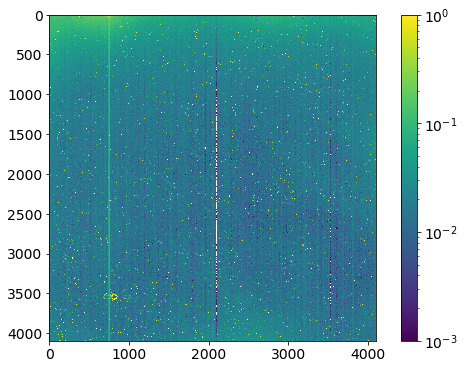

In [343]:
plt.figure (figsize=(9,6))
plt.imshow(measrate_e, vmin=1e-3, vmax=1., norm=colors.LogNorm() )
plt.colorbar()

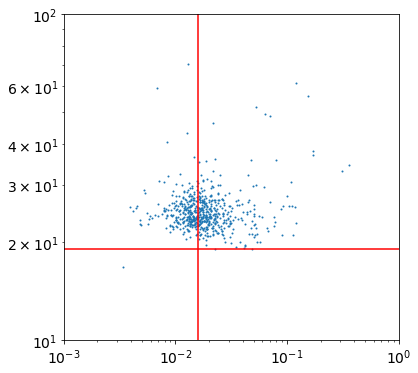

In [353]:
step = measrate_e.size // 600
plt.scatter ( measrate_e.flatten()[::step], np.sqrt(var[2]).flatten()[::step]*gain, s=1 )
plt.xlim(1e-3, 1)
plt.ylim(10,100)
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.016, color='r')
plt.axhline(19.04, color='r')

In [354]:
ramp.header()['EXPTIME'] * 0.016

52.113839999999996

In [235]:
var = np.zeros([3,4096,4096])

for ddx in range(3):
    data_type = dtypes_d[ddx]
    var_path = f'../data/output/{ramp_id}_{data_type}_S0-E-1_var.npy'    
    var[ddx] = np.load(var_path)

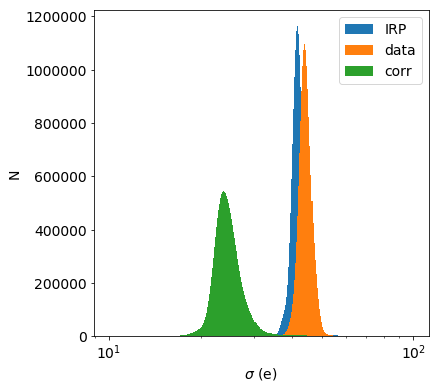

In [268]:
bins = np.logspace(1.,2,300)

stats_arr = np.zeros([var.shape[0], 6])
for ddx in range(3):
    var_sclip = np.sqrt(stats.sigmaclip(var[ddx]).clipped) * gain
    stats_arr[ddx, 0 ] = np.mean(var_sclip)
    stats_arr[ddx, 1 ] = np.std(var_sclip)
    stats_arr[ddx, 2:5 ] = np.quantile(var_sclip, [.16,.5,.84])    
    out=plt.hist( var[ddx][cds < sclip.upper]**0.5*gain, bins=bins, label=dtypes_d[ddx])
    stats_arr[ddx, 5] = out[1][np.argmax(out[0])]
plt.xlabel ( r'$\sigma$ (e)')
plt.ylabel ('N')
plt.legend ()
plt.xscale('log')

In [269]:
stats_arr[:,0]

array([41.75582272, 44.207752  , 24.51084152])

In [172]:
import glob

In [174]:
corr_list = glob.glob ( '../data/output/*corr*var.npy')

Text(0, 0.5, 'N')

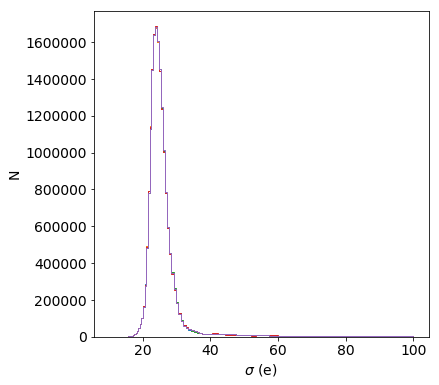

In [194]:
bins = np.logspace(1.,2,100)
stats_arr = np.zeros([len(corr_list), 6])
for cidx,cl in enumerate(corr_list):
    var = np.load(cl)
    stats_arr[cidx, 0 ] = np.mean(var)
    stats_arr[cidx, 1 ] = np.std(var)
    stats_arr[cidx, 2:5 ] = np.quantile(var, [.16,.5,.84])
    out=plt.hist( var.flatten()**0.5*gain, bins=bins, histtype='step')
    stats_arr[cidx, 5] = out[1][np.argmax(out[0])]
plt.xlabel ( r'$\sigma$ (e)')
plt.ylabel ( r'N')

In [192]:
stats_arr[:,3]

array([57.85755169, 57.86218916, 57.94837315, 57.85774577, 57.94804409])

In [193]:
stats_arr[:,5]

array([23.64489413, 23.64489413, 23.64489413, 23.64489413, 23.64489413])